In [ ]:
import torch
import os
import random
import json
import utils
import data_utils
import cbm
import plots
from IPython.display import display
from PIL import Image



In [ ]:

load_dir = "saved_models_remoteclip/eurosat_rgb_cbm_2025_11_23_00_42" 

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


# args.txt 로드
args_path = os.path.join(load_dir, "args.txt")
with open(args_path, "r") as f:
    args = json.load(f)

print(f"Loaded args from: {args_path}")
dataset = args["dataset"]

# RemoteCLIP과 일반 CLIP 처리 전처리기 로드
if args["backbone"] == 'remote_clip_vit_b_32':
    print("--- Loading RemoteCLIP Preprocess ---")
    remote_clip_path = args.get("remote_clip_path")
    if not remote_clip_path:
        raise ValueError("args.txt에 'remote_clip_path'가 없습니다. 모델 경로를 확인해주세요.")
    
    # utils.py의 함수
    _, target_preprocess = utils.load_remote_clip(
        args.get("clip_name", "ViT-B-32"), 
        remote_clip_path, 
        device
    )
else: # 일반 CLIP은 여기
    print(f"--- Loading Standard Preprocess for {args['backbone']} ---")
    _, target_preprocess = data_utils.get_target_model(args["backbone"], device)

# 모델 로드 
print("--- Loading CBM Model ---")
model = cbm.load_cbm(load_dir, device)
print("Model loaded successfully.")

Using device: cpu
Loaded args from: saved_models_remoteclip/eurosat_rgb_cbm_2025_11_23_00_42\args.txt
--- Loading RemoteCLIP Preprocess ---
Loading RemoteCLIP weights from: ../checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-B-32.pt
RemoteCLIP weights loaded successfully.
<All keys matched successfully>
--- Loading CBM Model ---
--- Loading RemoteCLIP Model as Backbone for CBM ---
Loading RemoteCLIP weights from: ../checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-B-32.pt
RemoteCLIP weights loaded successfully.
<All keys matched successfully>
Model loaded successfully.


In [ ]:
val_d_probe = dataset + "_val"
cls_file = data_utils.LABEL_FILES[dataset]

# Tensor 데이터 (모델 입력용)
val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)
# PIL 데이터 (시각화용 원본 이미지)
val_pil_data = data_utils.get_data(val_d_probe)

In [15]:
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

## Measure accuracy

In [ ]:
print("Calculating Accuracy...")
accuracy = utils.get_accuracy_cbm(model, val_data_t, device)
print("Validation Accuracy: {:.2f}%".format(accuracy*100))

Calculating Accuracy...


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [03:38<00:00,  9.92s/it]

Validation Accuracy: 92.50%


## Show final layer weights for some classes

You can build a Sankey diagram of weights by copying the incoming weights printed below into https://sankeymatic.com/build/

In [ ]:
# 모델 가중치
print("\n=== Global Concept Importance (Top 5 & Bottom 5) ===")
top_weights, top_weight_ids = torch.topk(model.final.weight, k=5, dim=1)
bottom_weights, bottom_weight_ids = torch.topk(model.final.weight, k=5, dim=1, largest=False)

# 상위 5개 클래스만
for i in range(min(5, len(classes))):
    print(f"Class {i} - {classes[i]}")
    
    # 긍정
    out_high = "  [+] Highest: "
    for j in range(top_weights.shape[1]):
        idx = int(top_weight_ids[i, j].cpu())
        out_high += "{}:{:.3f}, ".format(concepts[idx], top_weights[i, j])
    print(out_high)
    
    # 부정
    out_low = "  [-] Lowest : "
    for j in range(bottom_weights.shape[1]):
        idx = int(bottom_weight_ids[i, j].cpu())
        out_low += "{}:{:.3f}, ".format(concepts[idx], bottom_weights[i, j])
    print(out_low + "\n")


=== Global Concept Importance (Top 5 & Bottom 5) ===
Class 0 - AnnualCrop
  [+] Highest: plowed soil lines:1.654, long and narrow object:1.304, red or terracotta color:0.837, dense texture:0.748, an airport runway:0.700, 
  [-] Lowest : a shipping container:-1.022, a greenhouse:-0.872, snow or ice:-0.714, cracked surface:-0.693, a dry riverbed:-0.685, 

Class 1 - Forest
  [+] Highest: dark green:1.303, an isolated object:0.874, a fence or wall:0.811, a rock formation:0.757, dark brown:0.756, 
  [-] Lowest : industrial zone:-1.605, a roundabout:-1.367, symmetrical layout:-1.135, a large building:-0.820, low shrubs or bushes:-0.791, 

Class 2 - HerbaceousVegetation
  [+] Highest: a dry riverbed:1.513, glacier:1.052, linear pattern:0.976, an airplane:0.735, dark brown:0.562, 
  [-] Lowest : an airport runway:-1.258, canal:-0.857, a cultivated field:-0.679, light blue water:-0.653, a construction site:-0.609, 

Class 3 - Highway
  [+] Highest: winding path:1.708, a paved surface:1.659, a 

In [18]:
to_show = random.choices([i for i in range(len(classes))], k=2)

top_weights, top_weight_ids = torch.topk(model.final.weight, k=5, dim=1)
bottom_weights, bottom_weight_ids = torch.topk(model.final.weight, k=5, dim=1, largest=False)

#for i in to_show:
for i in range(0,10):
    print("Class {} - {}".format(i, classes[i]))
    out = "Highest weights: "
    for j in range(top_weights.shape[1]):
        idx = int(top_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], top_weights[i, j])
    print(out)
    out = "Lowest weights: "
    for j in range(bottom_weights.shape[1]):
        idx = int(bottom_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], bottom_weights[i, j])
    print(out + "\n")

Class 0 - AnnualCrop
Highest weights: plowed soil lines:1.654, long and narrow object:1.304, red or terracotta color:0.837, dense texture:0.748, an airport runway:0.700, 
Lowest weights: a shipping container:-1.022, a greenhouse:-0.872, snow or ice:-0.714, cracked surface:-0.693, a dry riverbed:-0.685, 

Class 1 - Forest
Highest weights: dark green:1.303, an isolated object:0.874, a fence or wall:0.811, a rock formation:0.757, dark brown:0.756, 
Lowest weights: industrial zone:-1.605, a roundabout:-1.367, symmetrical layout:-1.135, a large building:-0.820, low shrubs or bushes:-0.791, 

Class 2 - HerbaceousVegetation
Highest weights: a dry riverbed:1.513, glacier:1.052, linear pattern:0.976, an airplane:0.735, dark brown:0.562, 
Lowest weights: an airport runway:-1.258, canal:-0.857, a cultivated field:-0.679, light blue water:-0.653, a construction site:-0.609, 

Class 3 - Highway
Highest weights: winding path:1.708, a paved surface:1.659, a bridge:1.194, curved boundary:0.716, a cult

In [ ]:
# 전체 개념중에 실제로 사용된 개수
weight_contribs = torch.sum(torch.abs(model.final.weight), dim=0)
print("Num concepts with outgoing weights:{}/{}".format(torch.sum(weight_contribs>1e-5), len(weight_contribs)))

Num concepts with outgoing weights:99/100


## Explain model reasoning for random inputs


=== Local Explanation (Bar Plots) ===


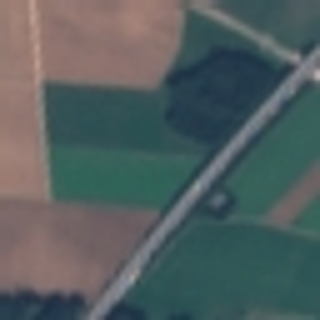

Image:4696 | GT: Highway
1st Pred: Highway (10.071) | 2nd Pred: AnnualCrop (4.207)


Image:2489 | GT: River
1st Pred: River (4.285) | 2nd Pred: SeaLake (2.379)


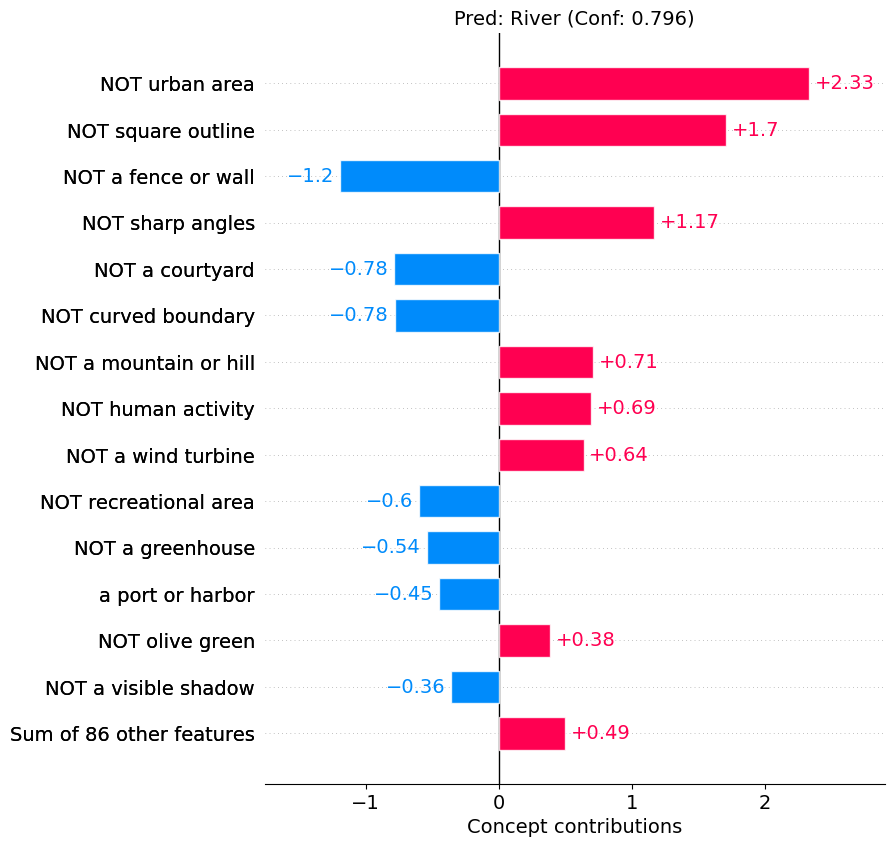

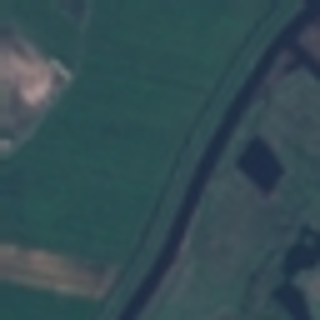

Image:4884 | GT: River
1st Pred: Pasture (4.361) | 2nd Pred: River (3.169)


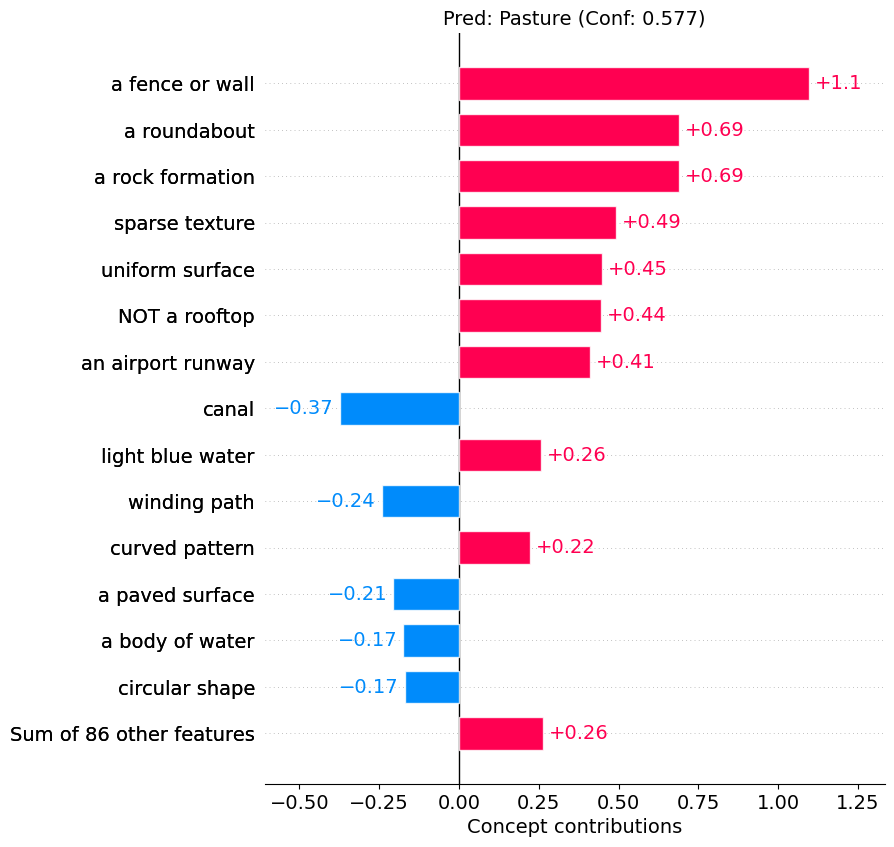

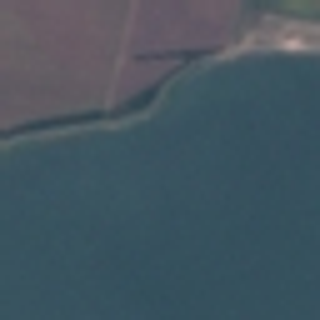

Image:5097 | GT: SeaLake
1st Pred: AnnualCrop (4.009) | 2nd Pred: SeaLake (3.678)


In [ ]:
# 개별 이미지 추론 및 시각화 
print("\n=== Local Explanation (Bar Plots) ===")
# 랜덤으로 4장 뽑아서 시각화
to_display = random.sample([i for i in range(len(val_pil_data))], k=4)

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        
        display(image.resize([320,320]))
        
        outputs, concept_act = model(x)
        
        # 상위 2개 예측 클래스 
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        
        gt_class = classes[int(label)]
        pred_class_1 = classes[top_classes[0]]
        pred_class_2 = classes[top_classes[1]]
        
        print(f"Image:{i} | GT: {gt_class}")
        print(f"1st Pred: {pred_class_1} ({top_logit_vals[0]:.3f}) | 2nd Pred: {pred_class_2} ({top_logit_vals[1]:.3f})")
        
        # 1순위 예측에 대한 설명 시각화
        for k in range(1): # 가장 높은 예측 하나만 봄
            target_idx = top_classes[k]
                      
            contributions = concept_act[0] * model.final.weight[target_idx, :]
            
            values = contributions.cpu().numpy()
            
            # 개념 이름에 "NOT" 붙이기 (concept_act(활성화 값)가 음수(< 0)인 경우 이름 앞에 "NOT")
            # 모델 내부에서 개념 점수는 정규화 되어 있다. (여기 ipynb 말고)
            # 점수가 음수라는 것은 해당 특징이 평균보다 현저히 적거나 없음을 의미
            # (예: 'Water' 점수가 음수 -> 'NOT Water' -> 물이 없다는 사실이 근거가 됨)
            feature_names = [("NOT " if concept_act[0][idx] < 0 else "") + concepts[idx] for idx in range(len(concepts))]
            
            # 그래프 그리기
            max_display = min(int(sum(abs(values)>0.005))+1, 15) # 최대 15개까지 표시
            title = f"Pred: {classes[target_idx]} (Conf: {conf[target_idx]:.3f})"
            
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=14)

Image:21 Gt:River, 1st Pred:River, 8.400, 2nd Pred:HerbaceousVegetation, 3.383


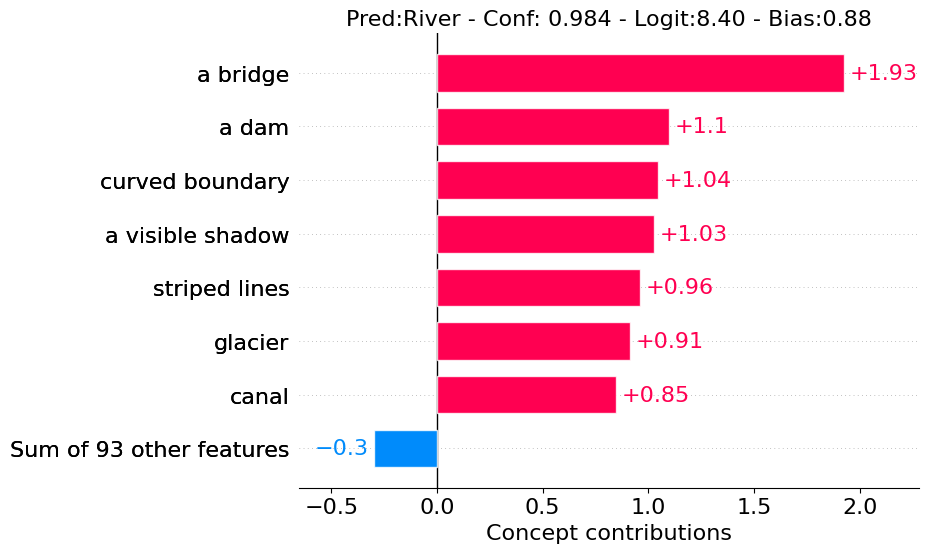

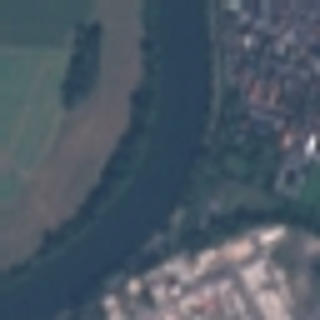

Image:29 Gt:River, 1st Pred:River, 7.702, 2nd Pred:Residential, 1.797


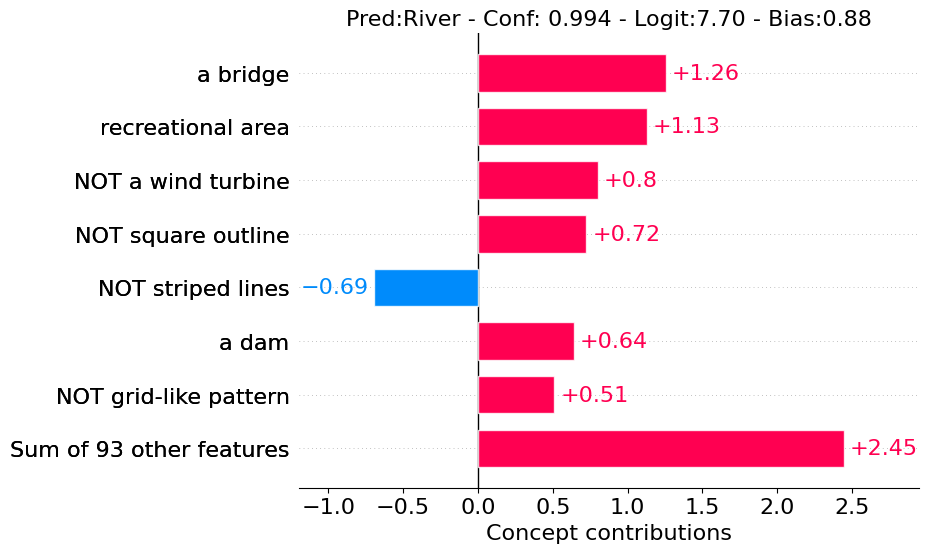

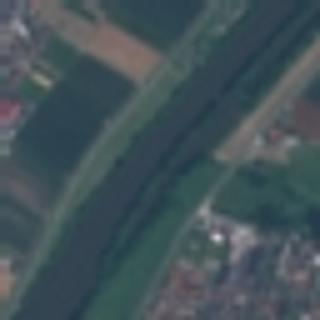

Image:30 Gt:River, 1st Pred:River, 6.989, 2nd Pred:Highway, 6.106


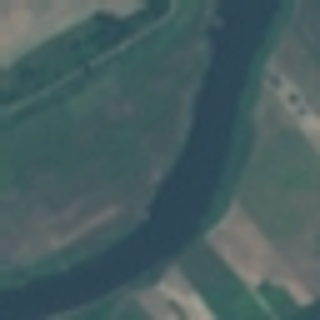

Image:31 Gt:River, 1st Pred:River, 9.447, 2nd Pred:Highway, 3.530


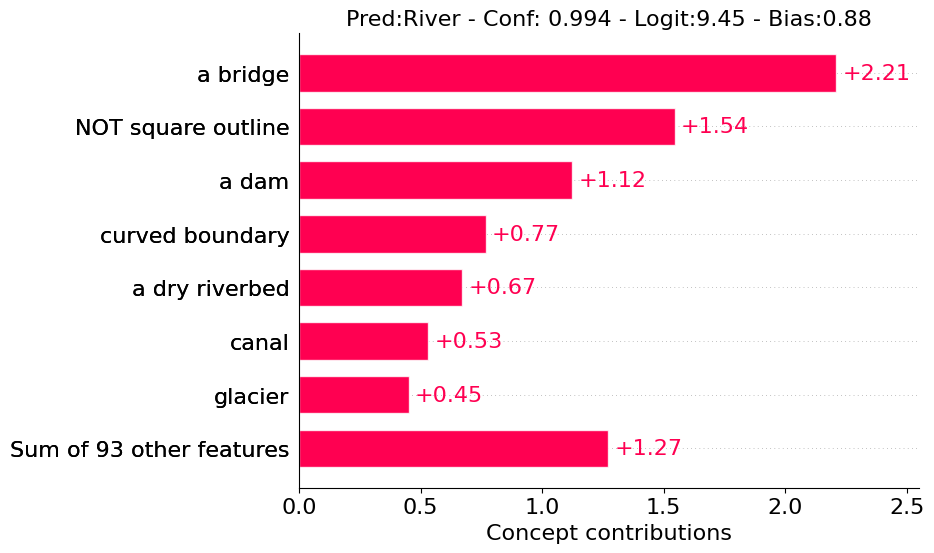

Image:35 Gt:River, 1st Pred:River, 5.945, 2nd Pred:Pasture, 2.841


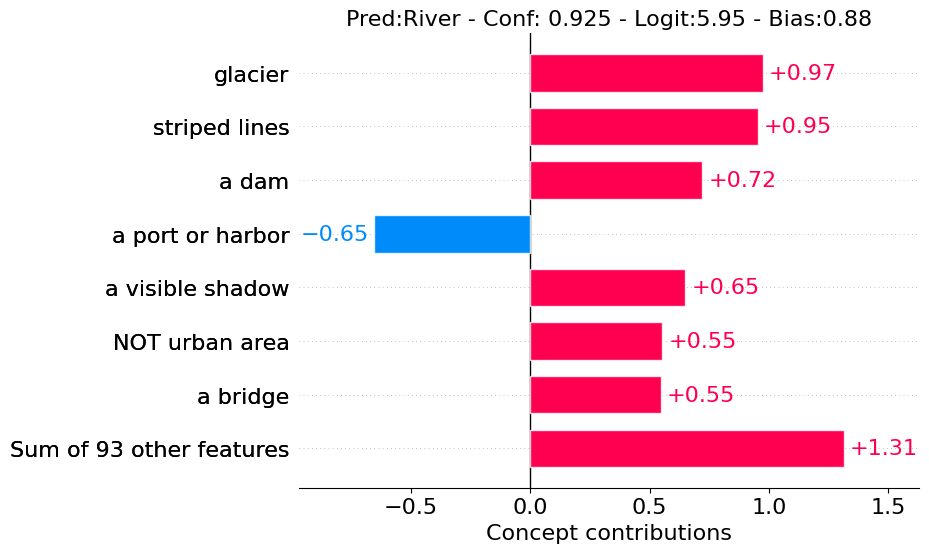

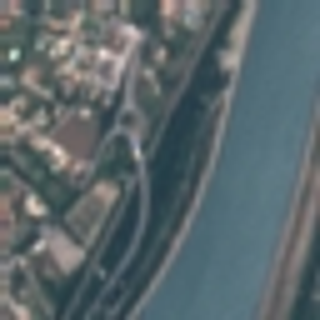

Image:46 Gt:River, 1st Pred:River, 7.717, 2nd Pred:Highway, 4.598


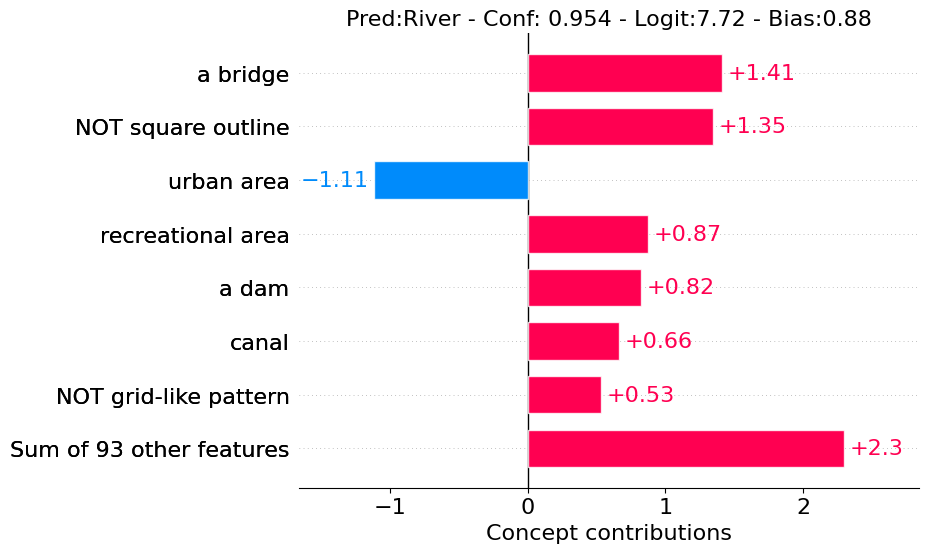

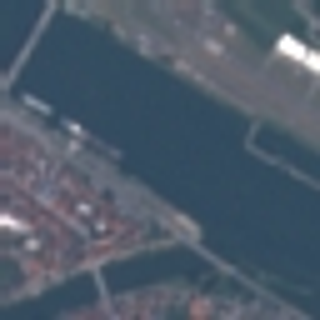

Image:51 Gt:River, 1st Pred:River, 5.851, 2nd Pred:HerbaceousVegetation, 2.033


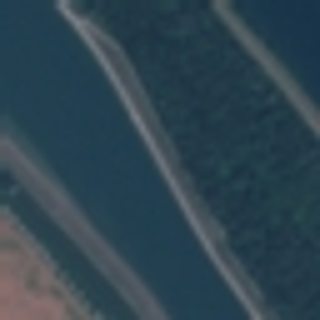

Image:55 Gt:River, 1st Pred:River, 7.009, 2nd Pred:AnnualCrop, 4.252


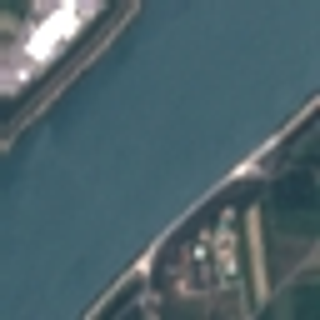

Image:58 Gt:River, 1st Pred:River, 8.871, 2nd Pred:Highway, 6.832


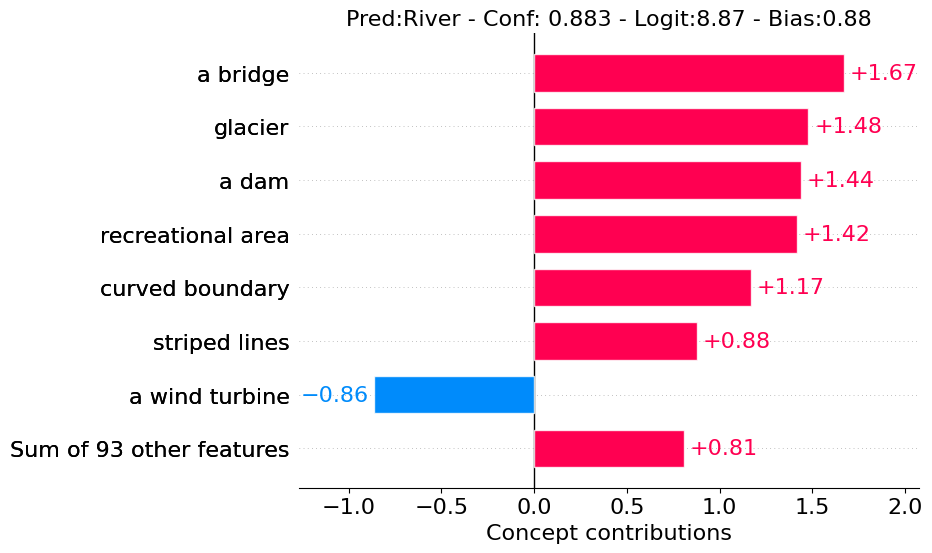

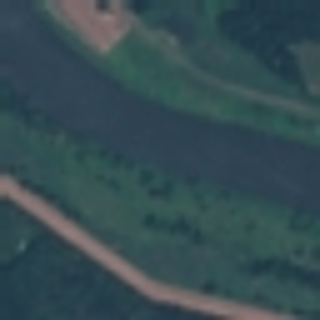

Image:62 Gt:River, 1st Pred:River, 8.498, 2nd Pred:Highway, 4.512


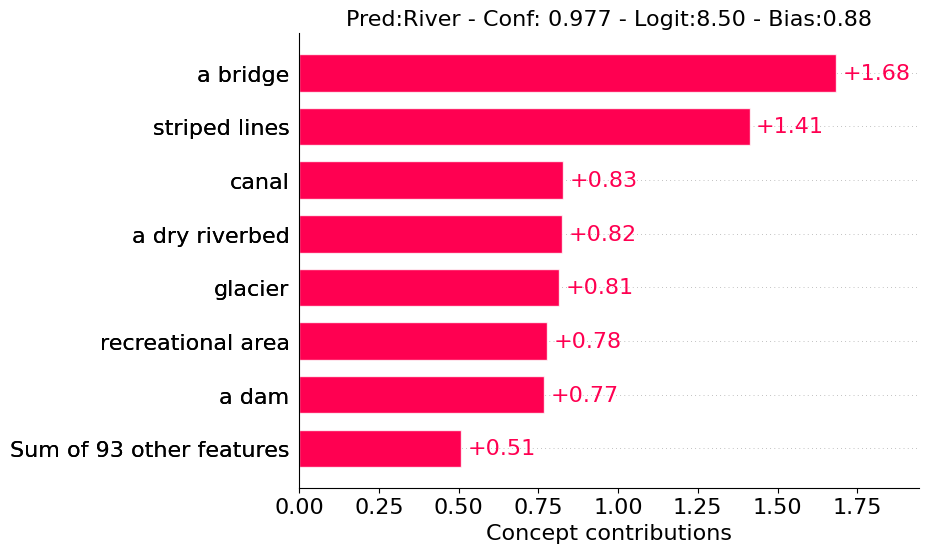

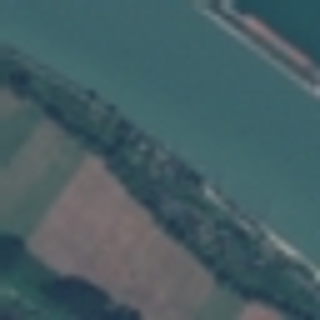

Image:78 Gt:River, 1st Pred:River, 7.648, 2nd Pred:AnnualCrop, 3.814


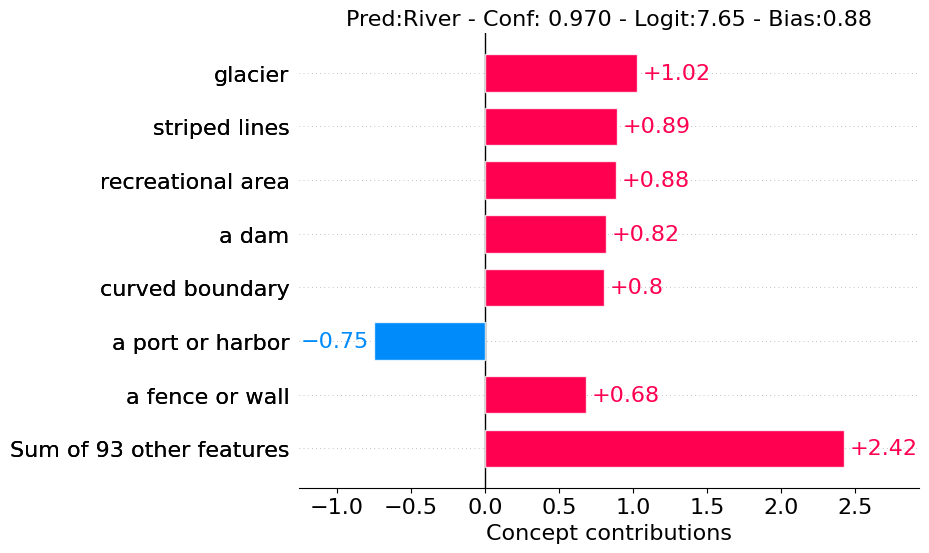

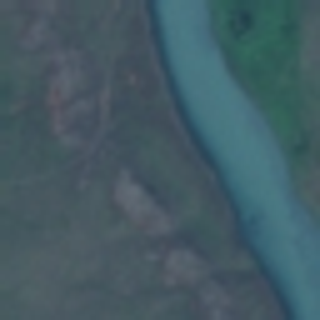

Image:85 Gt:River, 1st Pred:River, 8.328, 2nd Pred:HerbaceousVegetation, 4.204


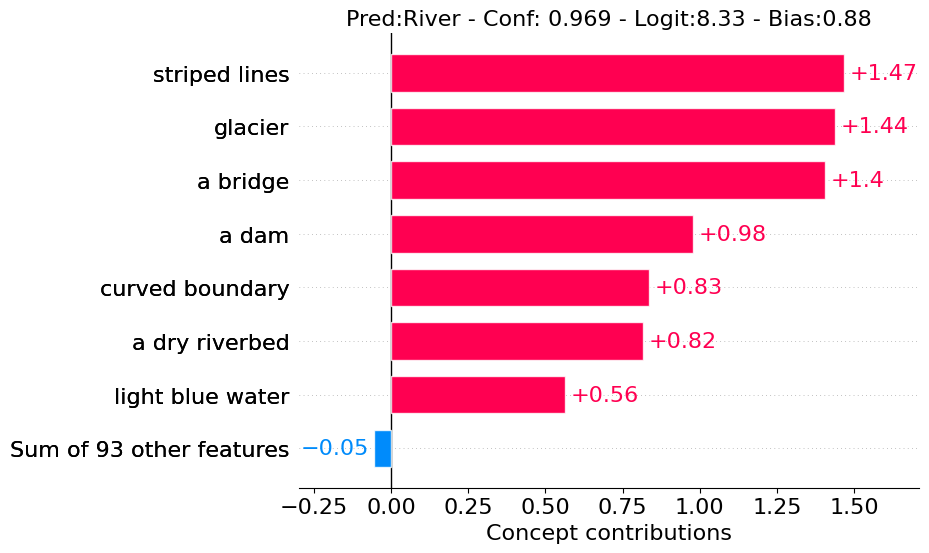

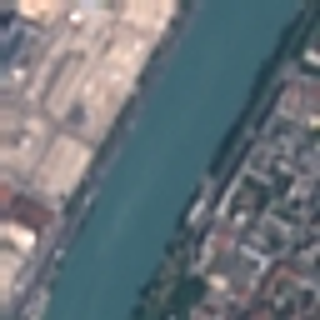

Image:97 Gt:River, 1st Pred:River, 9.518, 2nd Pred:Industrial, 4.497


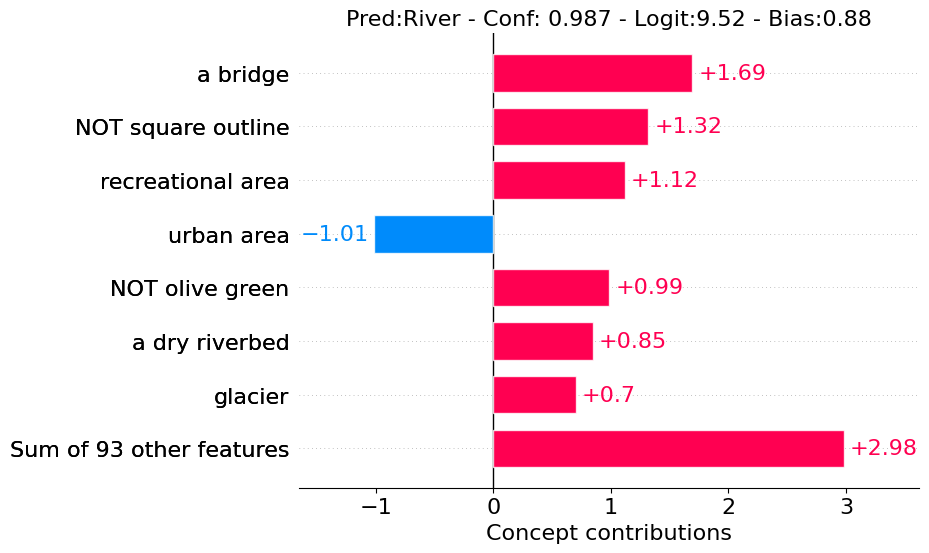

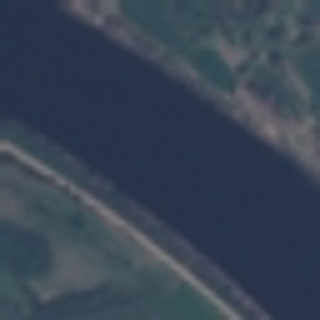

Image:100 Gt:River, 1st Pred:River, 8.711, 2nd Pred:Highway, 4.108


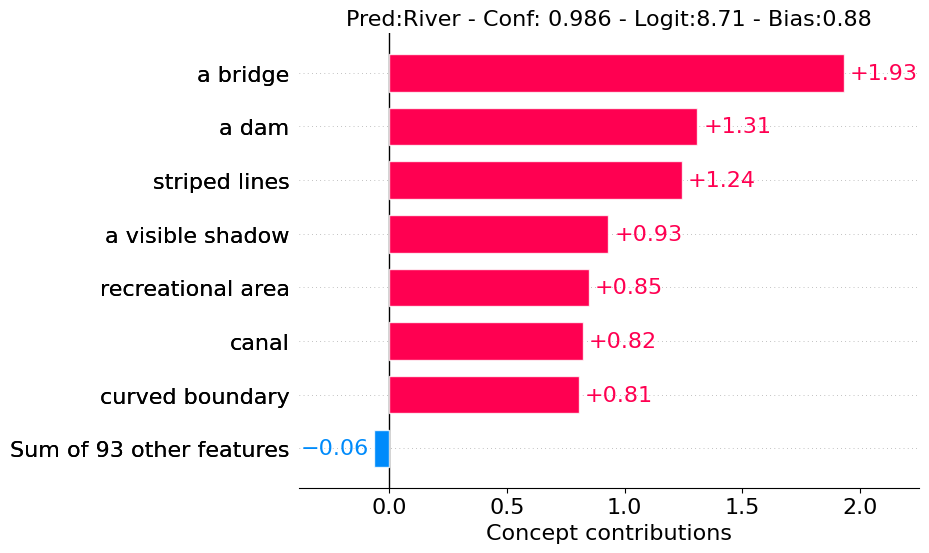

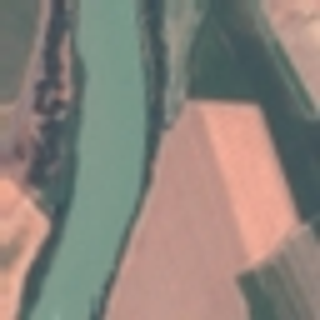

Image:110 Gt:River, 1st Pred:AnnualCrop, 6.783, 2nd Pred:River, 6.696


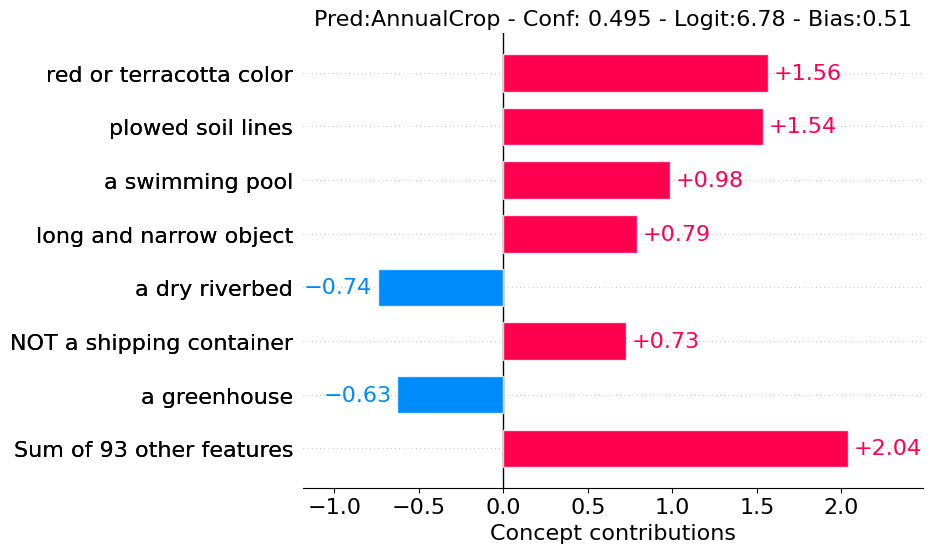

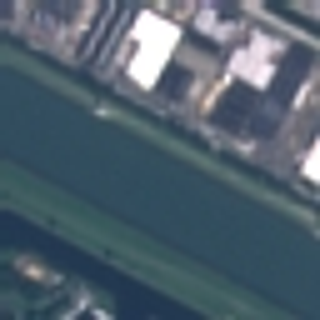

Image:119 Gt:River, 1st Pred:River, 7.340, 2nd Pred:Industrial, 6.217


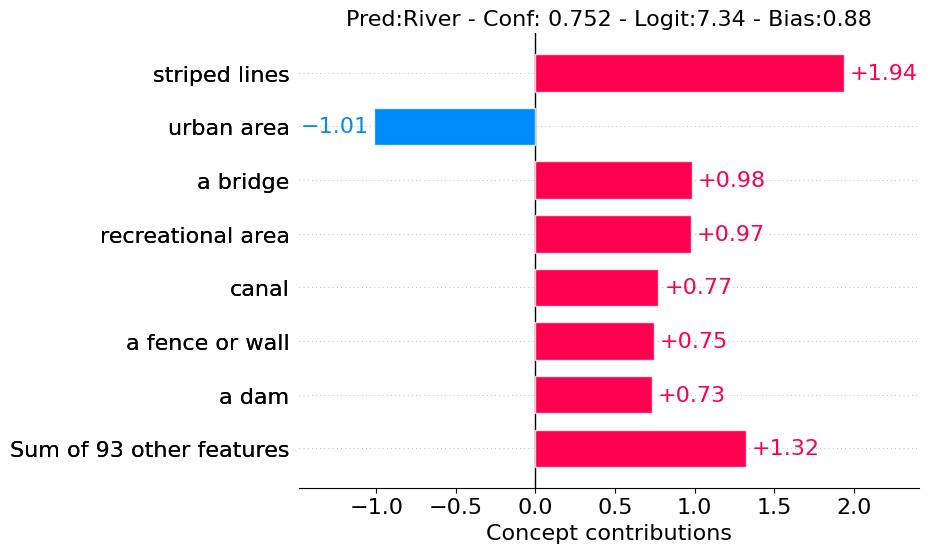

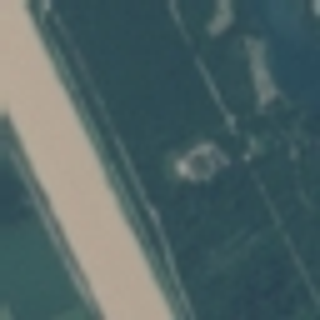

Image:134 Gt:River, 1st Pred:AnnualCrop, 5.361, 2nd Pred:River, 4.781


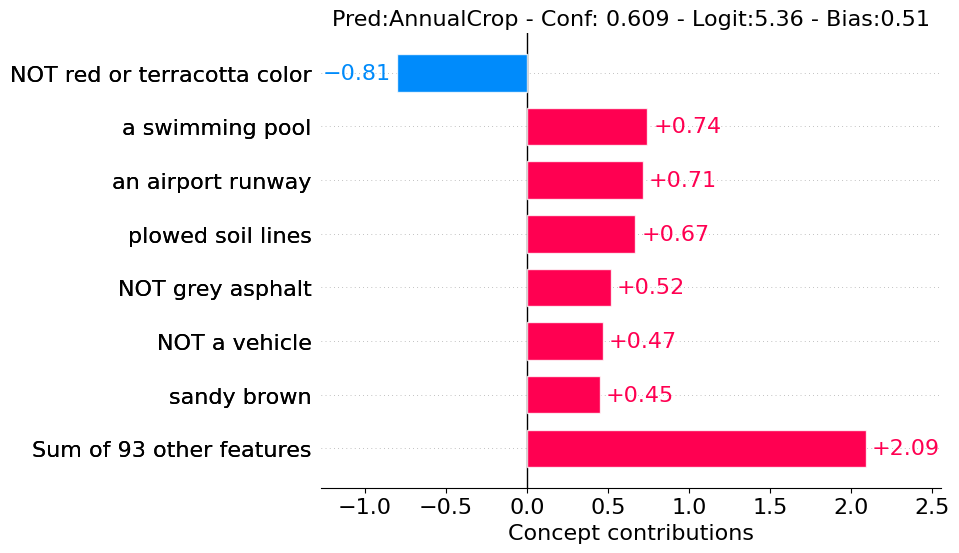

Image:139 Gt:River, 1st Pred:River, 7.455, 2nd Pred:Highway, 5.919


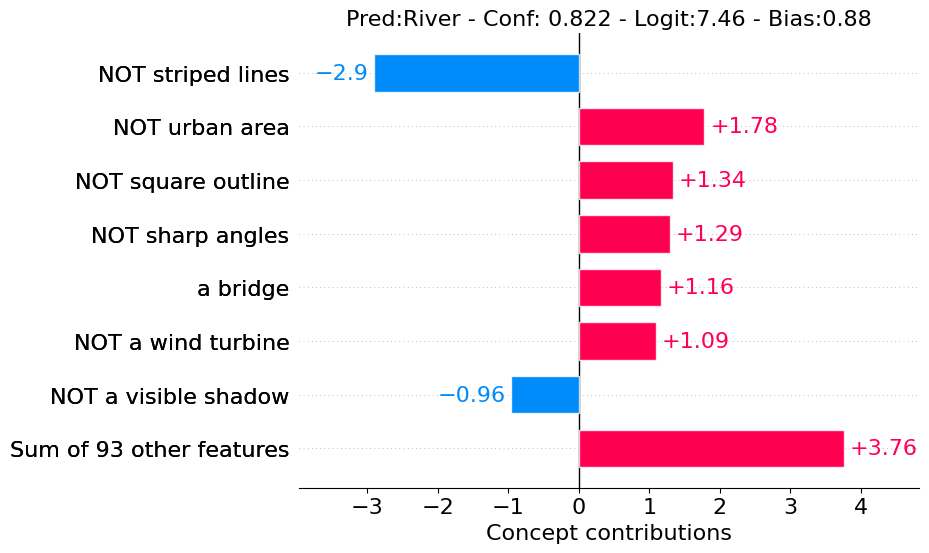

Image:149 Gt:River, 1st Pred:River, 6.164, 2nd Pred:AnnualCrop, 3.688


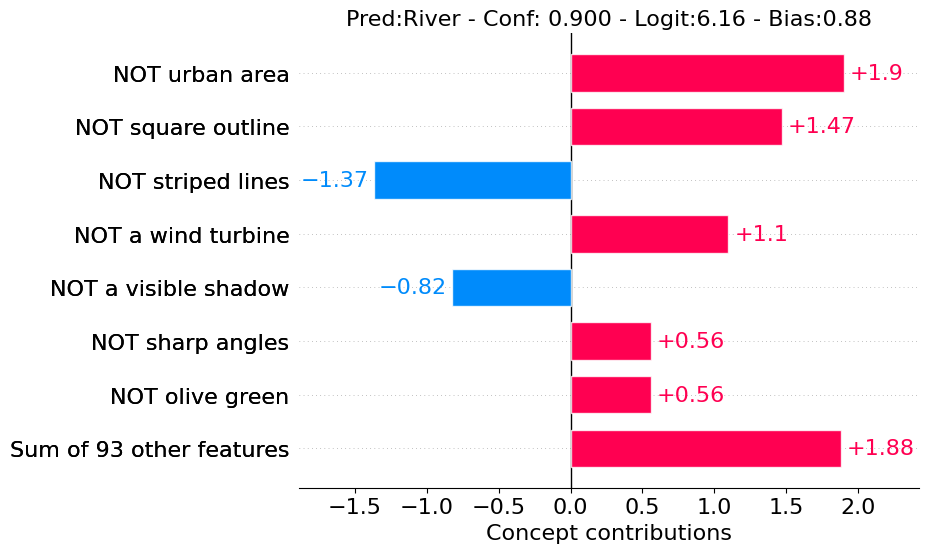

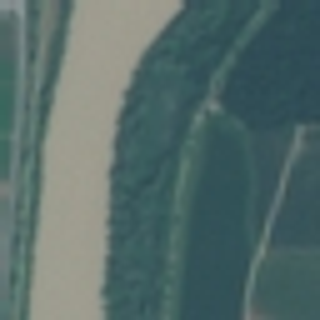

Image:185 Gt:River, 1st Pred:River, 7.229, 2nd Pred:AnnualCrop, 4.535


In [ ]:
target_class_name = 'Pasture' # 클래스
num_samples = 20              # 이미지 수


with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i] # 원본 이미지
        x_tensor, label_tensor = val_data_t[i] 
        x = x_tensor.unsqueeze(0).to(device) # x_tensor
        display(image.resize([320,320]))

        outputs, concept_act = model(x)

        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label_tensor)], classes[top_classes[0]], top_logit_vals[0],
                                                                               classes[top_classes[1]], top_logit_vals[1]))

        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][j] < 0 else "") + concepts[j] for j in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                                                                                 conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)
# 클래스 선택하고 거기서 아무거나 num_samples 개 이미지

'Residential' 클래스(인덱스: 7)의 첫 20개 샘플을 표시합니다:


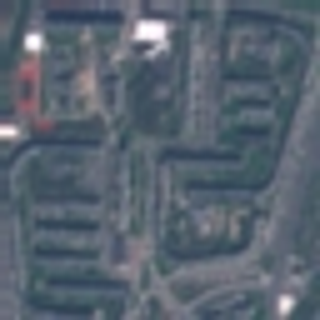

Image:7 Gt:Residential, 1st Pred:Residential, 6.928, 2nd Pred:Industrial, 5.106


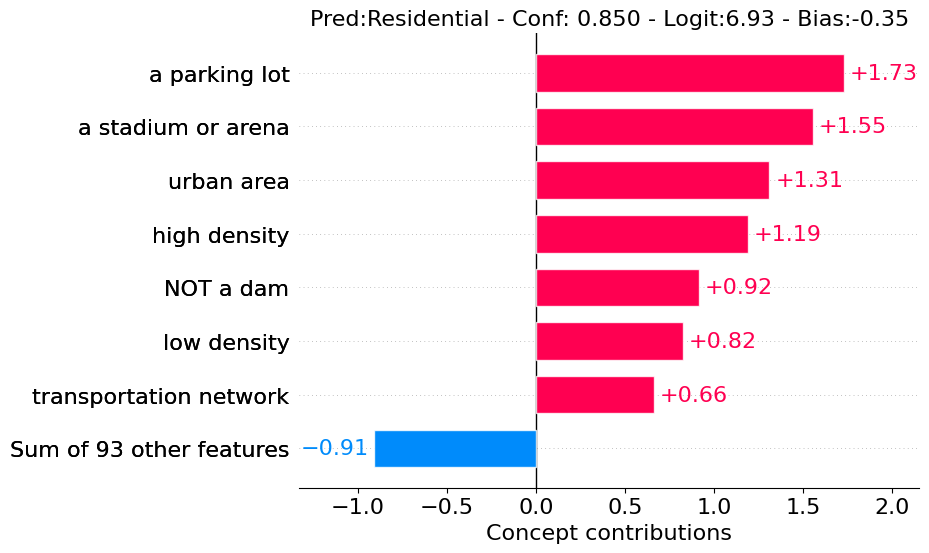

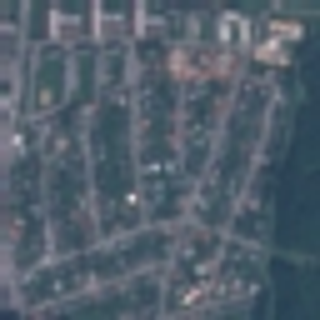

Image:12 Gt:Residential, 1st Pred:Residential, 7.353, 2nd Pred:Industrial, 3.933


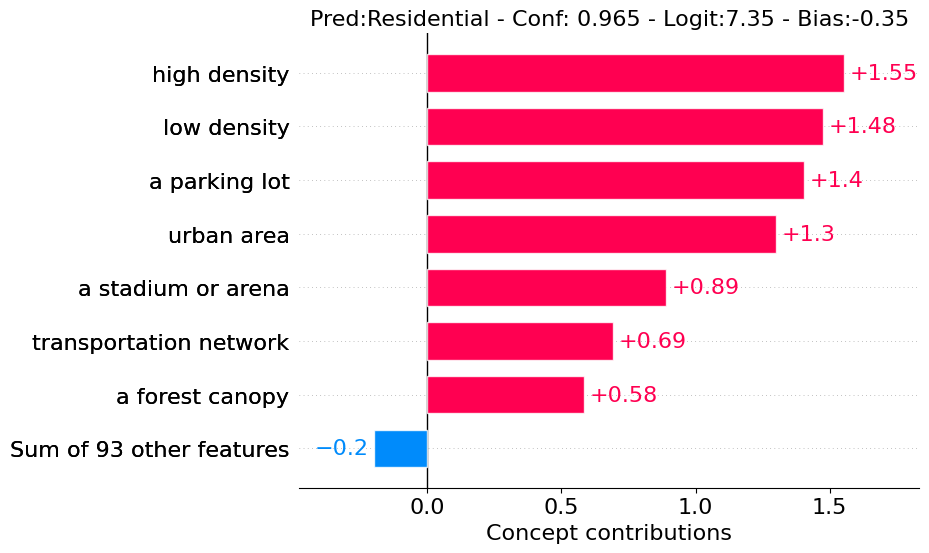

Image:18 Gt:Residential, 1st Pred:Residential, 10.767, 2nd Pred:Industrial, 4.976


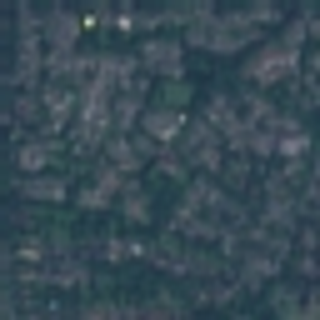

Image:22 Gt:Residential, 1st Pred:Residential, 9.680, 2nd Pred:Forest, 2.514


Image:24 Gt:Residential, 1st Pred:Residential, 8.528, 2nd Pred:Industrial, 4.483


Image:26 Gt:Residential, 1st Pred:Residential, 11.464, 2nd Pred:Industrial, 4.383


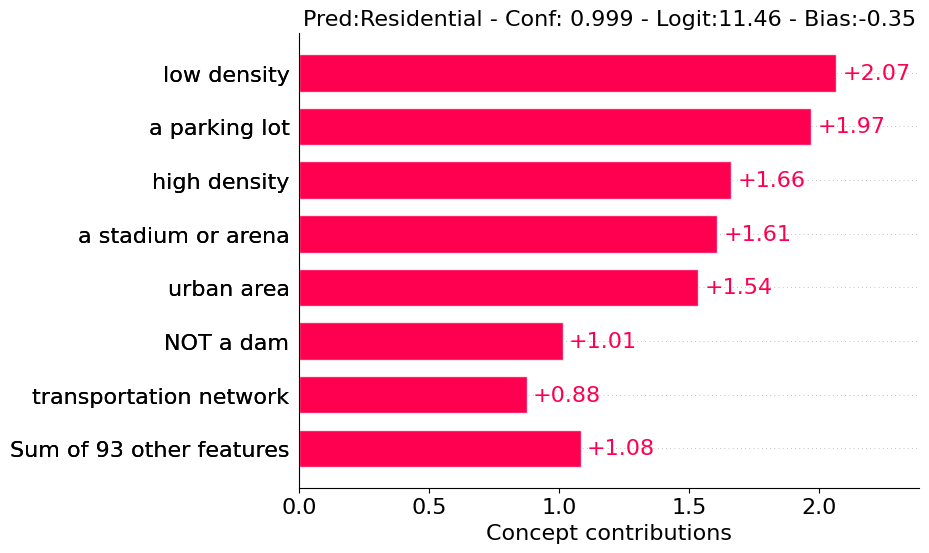

Image:45 Gt:Residential, 1st Pred:Residential, 8.944, 2nd Pred:Industrial, 6.368


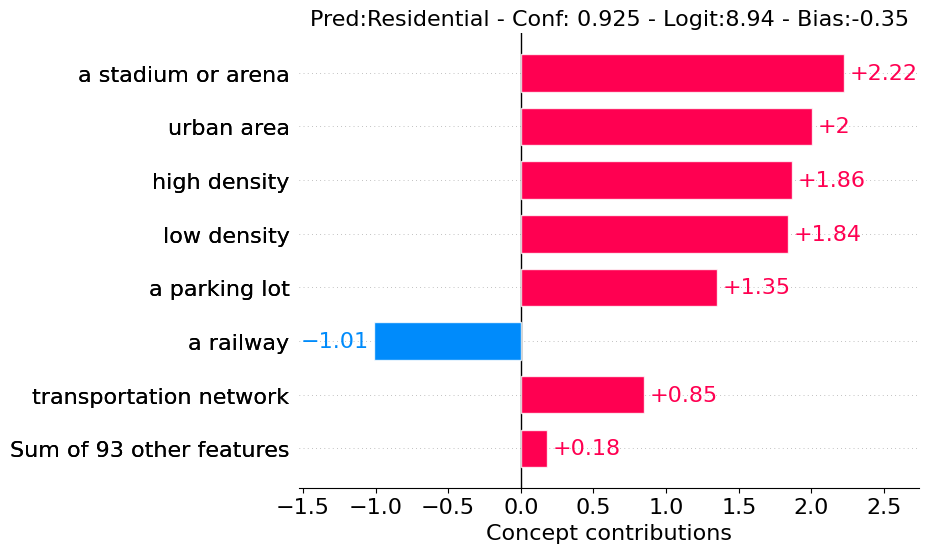

Image:63 Gt:Residential, 1st Pred:Residential, 7.731, 2nd Pred:Highway, 2.938


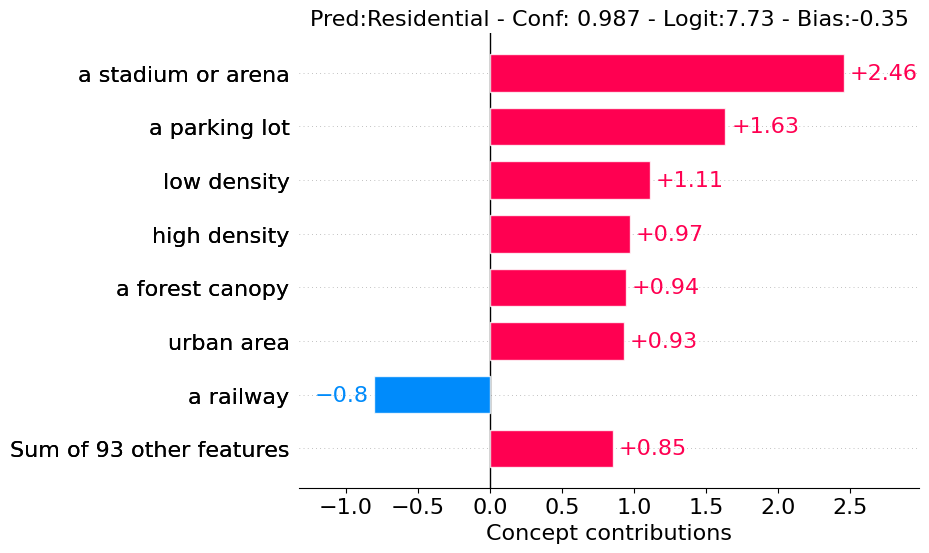

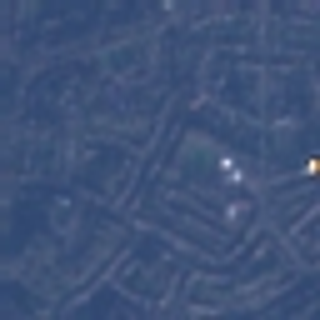

Image:68 Gt:Residential, 1st Pred:HerbaceousVegetation, 2.053, 2nd Pred:Highway, 1.972


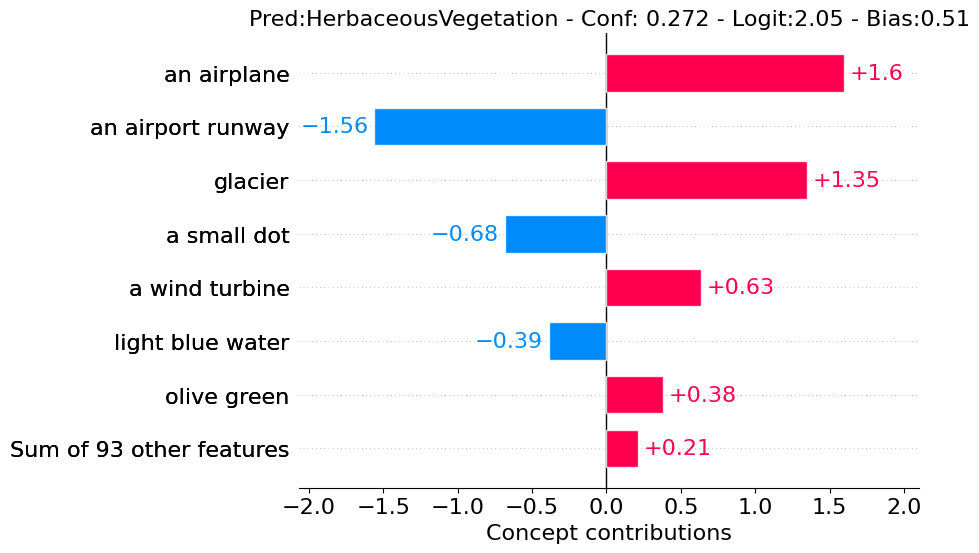

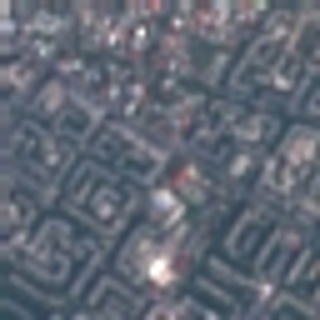

Image:88 Gt:Residential, 1st Pred:Residential, 9.285, 2nd Pred:Industrial, 6.549


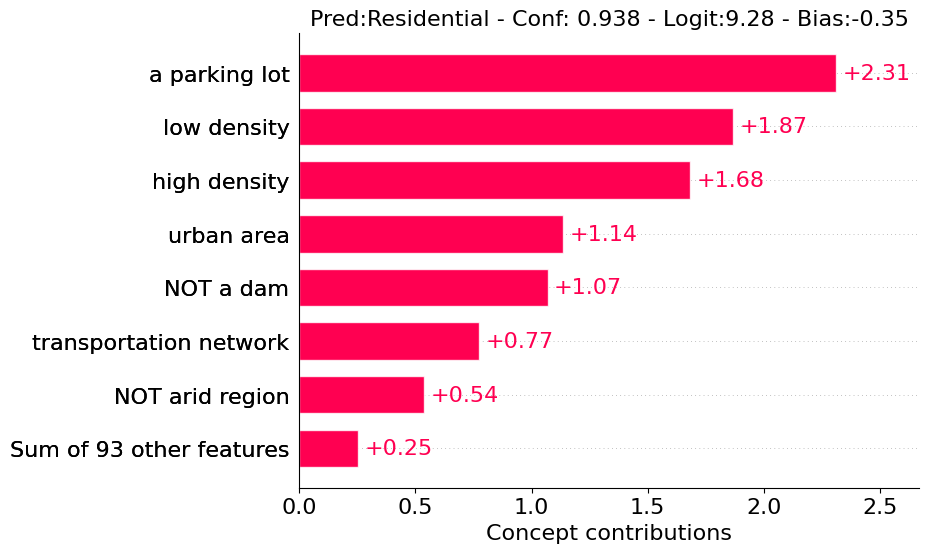

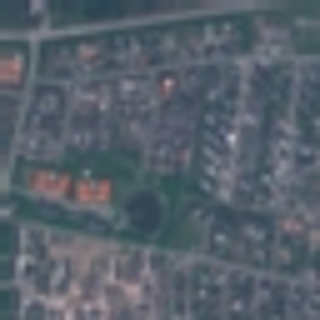

Image:93 Gt:Residential, 1st Pred:Residential, 8.164, 2nd Pred:Industrial, 4.219


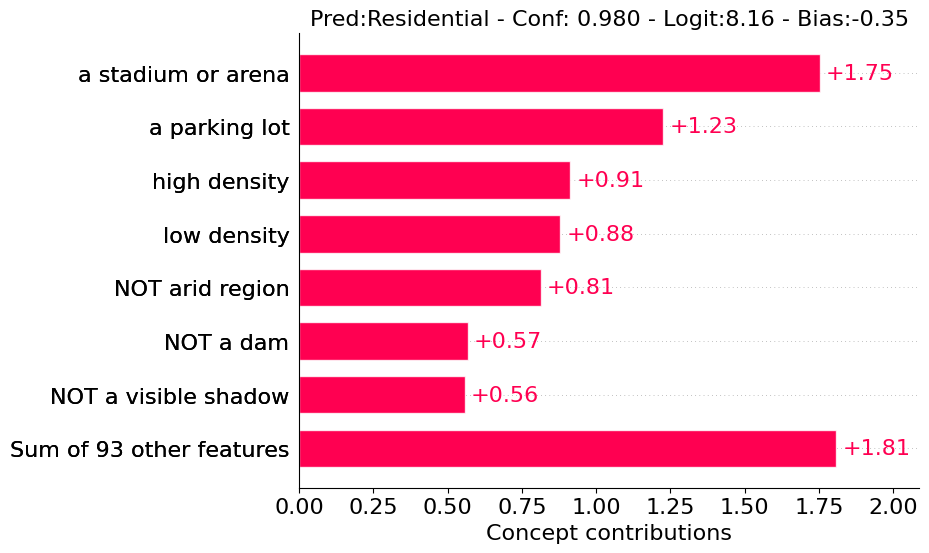

Image:94 Gt:Residential, 1st Pred:Residential, 10.356, 2nd Pred:Industrial, 6.223


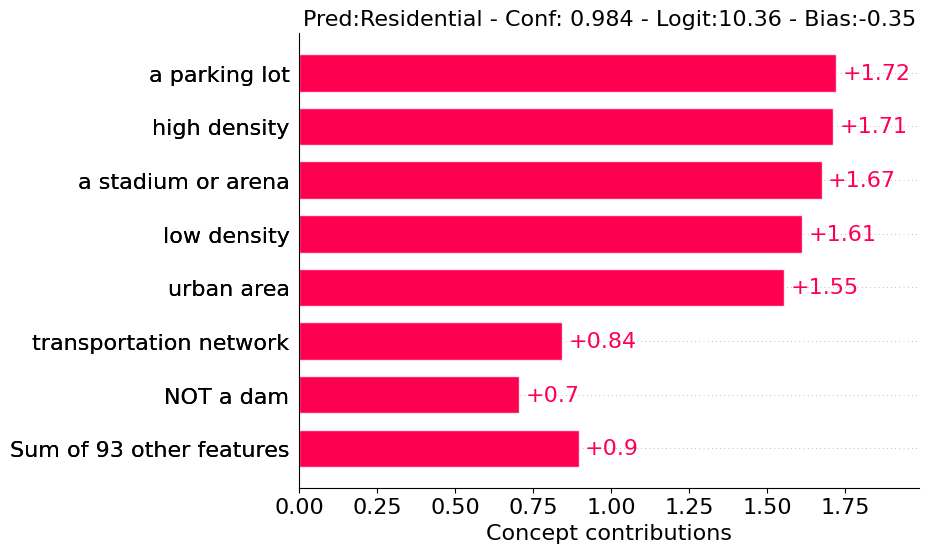

Image:104 Gt:Residential, 1st Pred:Residential, 8.962, 2nd Pred:Industrial, 3.273


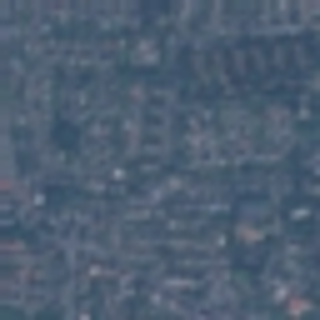

Image:112 Gt:Residential, 1st Pred:Residential, 9.229, 2nd Pred:Industrial, 4.371


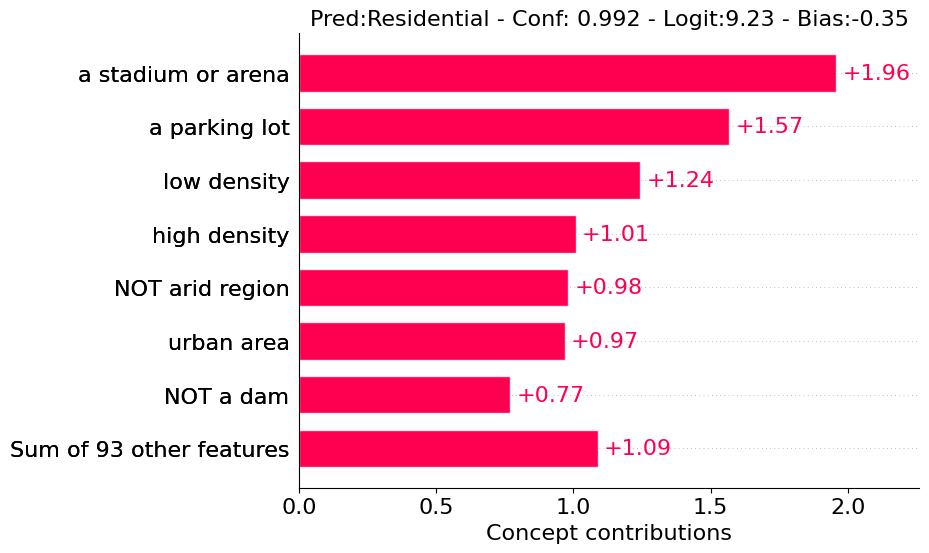

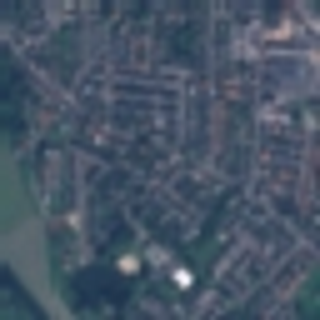

Image:131 Gt:Residential, 1st Pred:Residential, 9.024, 2nd Pred:Industrial, 3.883


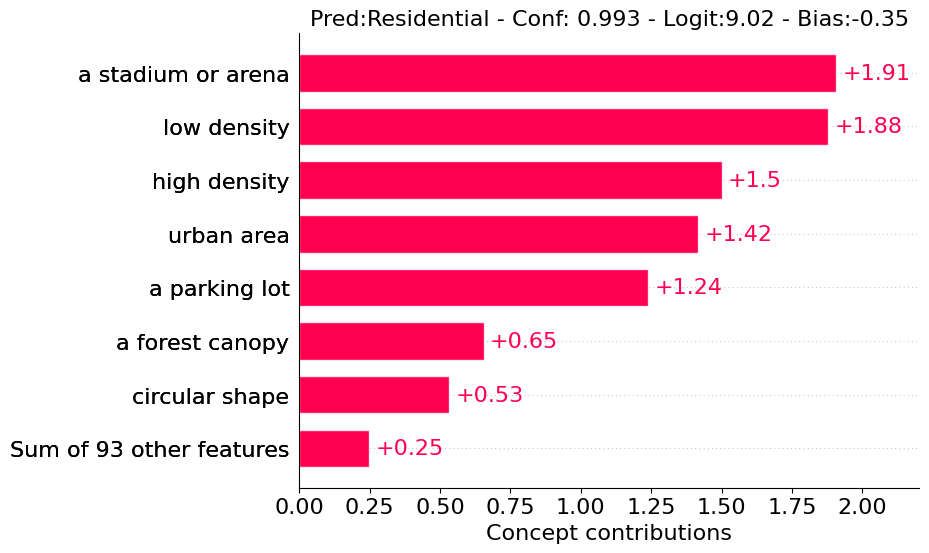

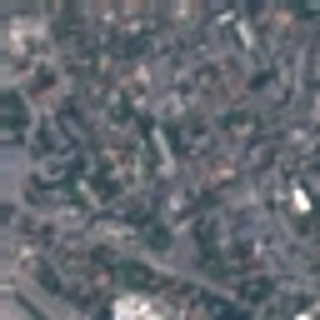

Image:137 Gt:Residential, 1st Pred:Residential, 7.829, 2nd Pred:Industrial, 5.394


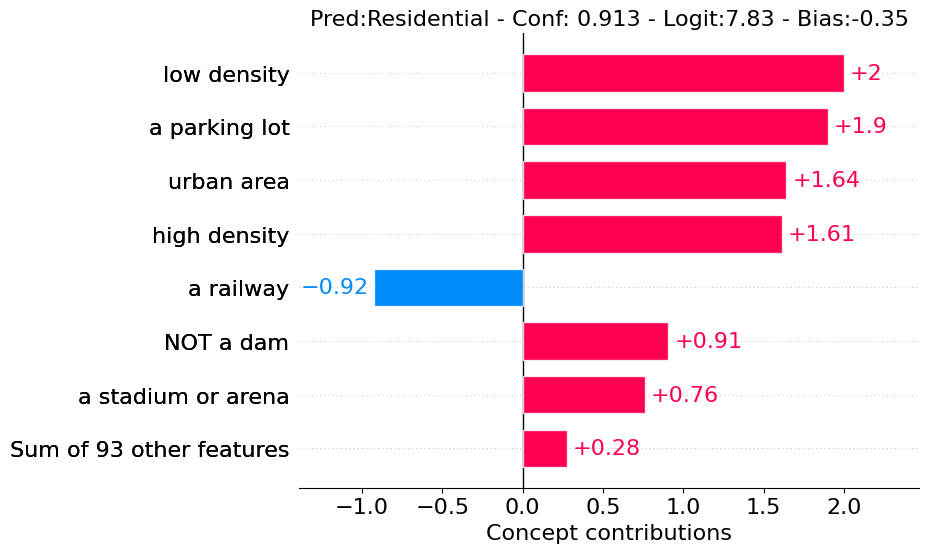

Image:142 Gt:Residential, 1st Pred:Residential, 8.914, 2nd Pred:Industrial, 3.059


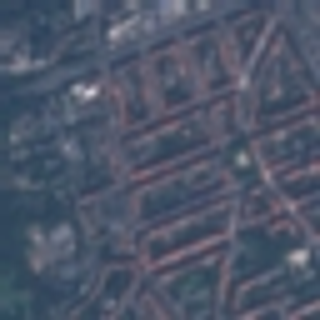

Image:162 Gt:Residential, 1st Pred:Residential, 9.697, 2nd Pred:Industrial, 4.448


Image:163 Gt:Residential, 1st Pred:Residential, 8.673, 2nd Pred:Industrial, 4.793


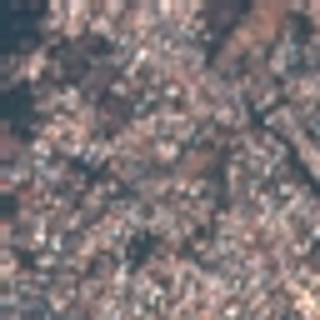

Image:166 Gt:Residential, 1st Pred:Residential, 9.906, 2nd Pred:PermanentCrop, 4.849


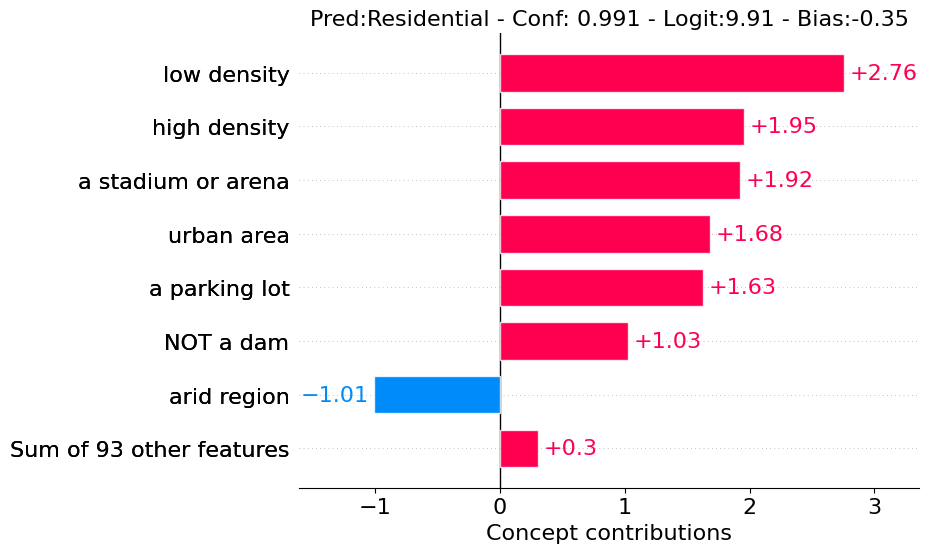

In [ ]:
target_class_name = 'Residential'
num_samples = 20                

target_label_index = classes.index(target_class_name)
target_indices = [i for i, (_, label) in enumerate(val_data_t) if int(label) == target_label_index]

num_samples_to_draw = min(num_samples, len(target_indices)) 
to_display = target_indices[:num_samples_to_draw] # 랜덤으로 뽑지말고 앞에서 부터 뽑기 

# 위의 셀의 코드 유지
with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i] # 원본 이미지 로딩
        x_tensor, label_tensor = val_data_t[i] 
        x = x_tensor.unsqueeze(0).to(device) # x_tensor 사용
        display(image.resize([320,320]))

        outputs, concept_act = model(x)

        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label_tensor)], classes[top_classes[0]], top_logit_vals[0],
                                                                               classes[top_classes[1]], top_logit_vals[1]))

        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][j] < 0 else "") + concepts[j] for j in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                                                                                 conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)